In [141]:
# Load libraries
library(quanteda)
library(ggrepel)
library(textclean)
library(tidyverse)
library(glmnet)
library(pROC)
library(sentimentr)
library(stm)
library(wordcloud)           
library(igraph)
library(tidyverse)
library(sentimentr)

### Pre-processing the data (split)

In [142]:
jd <- readRDS("/Users/ivanhung/Documents/GitHub/text-mining/w3/jd_small.RDS")

In [143]:
names(jd)

# keep only needed cols + drop missing
jd <- jd %>%
  select(FullDescription, SalaryNormalized, Category, ContractType, ContractTime) %>%
  rename(salaryNormalized = SalaryNormalized) %>%
  filter(!is.na(FullDescription), !is.na(salaryNormalized))

stopifnot(nrow(jd) >= 10000)

# random split: 8000 train, rest test (should be 2000 if exactly 10000 rows)
train_id <- sample(seq_len(nrow(jd)), 8000)
train <- jd[train_id, ]
test  <- jd[-train_id, ]

nrow(train); nrow(test)

[1] "Id"                 "Title"              "FullDescription"   
 [4] "LocationRaw"        "LocationNormalized" "ContractType"      
 [7] "ContractTime"       "Company"            "Category"          
[10] "SalaryRaw"          "SalaryNormalized"   "SourceName"

[1] 8000

[1] 2000

In [144]:
make_dfm_ngrams <- function(text_vec, n = 2, min_termfreq = 5) {
  corp <- corpus(text_vec)
  toks <- tokens(
    corp,
    remove_punct = TRUE,
    remove_numbers = TRUE,
    remove_symbols = TRUE
  ) %>%
    tokens_tolower() %>%
    tokens_remove(stopwords("en")) %>%
    tokens_ngrams(n = 1:n)
  
  dfm(toks) %>%
    dfm_trim(min_termfreq = min_termfreq)
}

dfm_train <- make_dfm_ngrams(train$FullDescription, n = 2, min_termfreq = 5)
dfm_test  <- make_dfm_ngrams(test$FullDescription,  n = 2, min_termfreq = 5)

# align features (keep only training vocab)
dfm_test <- dfm_match(dfm_test, features = featnames(dfm_train))

x_train <- as(dfm_train, "dgCMatrix")
x_test  <- as(dfm_test,  "dgCMatrix")
y_train <- train$salaryNormalized
y_test  <- test$salaryNormalized

# LASSO regression
cv_ngram <- cv.glmnet(x_train, y_train, alpha = 1, family = "gaussian")
pred_ngram <- as.numeric(predict(cv_ngram, newx = x_test, s = "lambda.min"))

rmse_ngram <- sqrt(mean((pred_ngram - y_test)^2))
rmse_ngram

[1] 12875.14

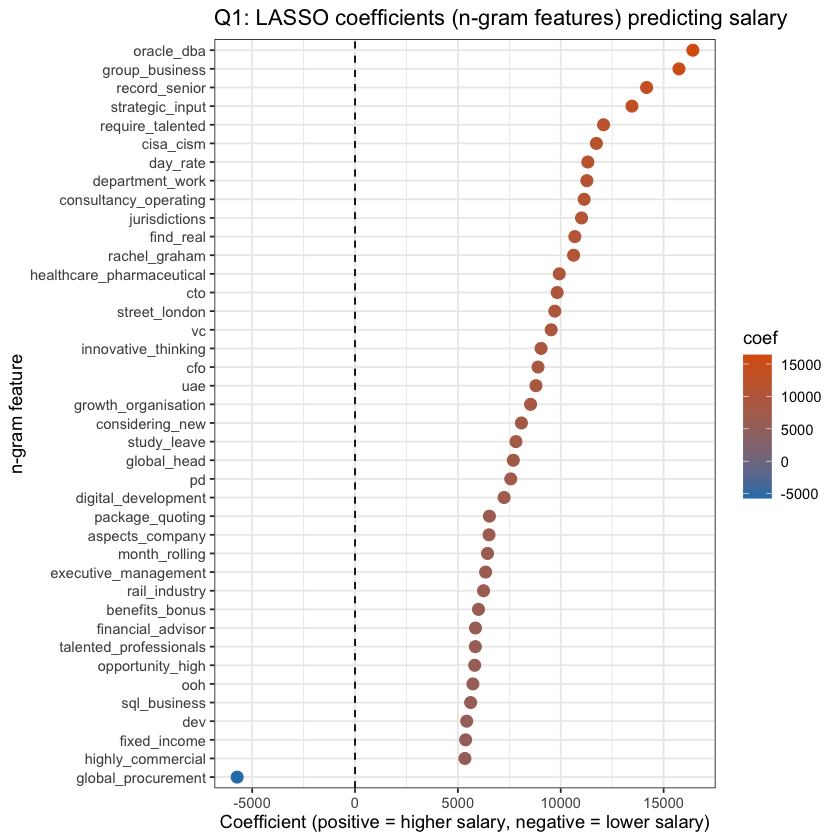

In [145]:
coef_mat <- coef(cv_ngram, s = "lambda.min")

coef_df <- as.matrix(coef_mat) %>%
  as.data.frame() %>%
  rownames_to_column("term") %>%
  rename(coef = `lambda.min`) %>%
  filter(term != "(Intercept)", coef != 0) %>%
  arrange(desc(abs(coef))) %>%
  slice_head(n = 40)

ggplot(coef_df, aes(x = coef, y = reorder(term, coef), color = coef)) +
  geom_vline(xintercept = 0, linetype = "dashed") +
  geom_point(size = 3) +
  scale_color_gradient(low = "#2C7FB8", high = "#D95F0E") +
  theme_bw() +
  labs(
    title = "Q1: LASSO coefficients (n-gram features) predicting salary",
    x = "Coefficient (positive = higher salary, negative = lower salary)",
    y = "n-gram feature"
  )

In [146]:
# stm::textProcessor expects a data.frame with a 'documents' column
processed <- textProcessor(
  documents = train$FullDescription,
  metadata  = train,
  lowercase = TRUE,
  removestopwords = TRUE,
  removenumbers = TRUE,
  removepunctuation = TRUE
)

prep <- prepDocuments(processed$documents, processed$vocab, processed$meta)
docs  <- prep$documents
vocab <- prep$vocab
meta  <- prep$meta

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 15863 of 27180 terms (15863 of 859696 tokens) due to frequency 
Your corpus now has 8000 documents, 11317 terms and 843833 tokens.

In [147]:
set.seed(70104) # keep seed before STM for reproducibility
stm_fit <- stm(documents = docs, vocab = vocab, K = 20,
               data = meta, max.em.its = 75, init.type = "Spectral")

stm_fit

lt <- labelTopics(stm_fit, n = 10)  # shows FREX, Highest Prob, etc.
lt$frex[1:5]  # peek

# Find “most representative docs” for a topic you’re inspecting
# example: topic 7
thoughts7 <- findThoughts(stm_fit, texts = meta$FullDescription, n = 2, topics = 7)
thoughts7$docs

Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Using only 10000 most frequent terms during initialization...
	 Finding anchor words...
 	....................
	 Recovering initialization...
 	....................................................................................................
Initialization complete.
....................................................................................................
Completed E-Step (1 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -6.922) 
....................................................................................................
Completed E-Step (1 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -6.654, relative change = 3.875e-02) 
....................................................................................................
Completed E-Step (1 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -6.608, relat

A topic model with 20 topics, 8000 documents and a 11317 word dictionary.

[1] "dealership" "book"       "pub"        "plant"      "ppc"

$`Topic 7`
[1] "This fast growing asbestos consultancy that provides high quality services to a wide portfolio of clients is presently looking for an Asbestos Surveyor/Analyst to cover a mixed bag of contracts in and around the Scotland area. The ideal candidate must have at least 12 years proven experience within the asbestos industry and must hold the Asbestos P**** P**** and P**** certificates. The role will entail carrying out **** stage asbestos clearances, smoke, background, leak reassurances, visual, reoccupation and personal air testing. Additional duties will include carrying out asbestos management, refurbishment and demolitions surveys on a various buildings  commercial and industrial. Supervising asbestos contractors on site and liaising with clients. Producing asbestos reports. In general, you will be an allrounder, flexible, be well versed in all aspects of the Health and Safety legislation in relation to asbestos, have good communication skills, both written and verbal and have the ability to work on own initiative. This company in return, offers an attractive salary, company vehicle and other benefits. Future Select specialize in recruiting staff in the Asbestos Industry. We currently have over a **** clients that are looking for candidates that have from 3 months experience to people with over 20 years in the industry. We have vacancies for Assistant Asbestos Surveyors, Basic Asbestos Surveyor, Lead Asbestos Surveyors, Asbestos Analysts, Asbestos Project Managers, Asbestos Junior Consultants, Asbestos Senior Consultants, Asbestos Laboratory Technicians, Asbestos Removal Contracts Managers, Asbestos Supervisors, and Asbestos Operations Manager to Asbestos Director level positions. Salaries ranging ****k. We are recruiting for Asbestos clients in all regions throughout the UK. asbestos surveyor analyst asbestos p**** p**** p**** asbestos consultant asbestos technician asbestos management refurbishment amp; demolition surveys **** stage clearances leak background smoke visual tests scotland"                                                                                                                                                                                                                                                                                                                                    
[2] "Due to ongrowth of the business, our client, an established asbestos management consultancy that has a national presence and at the same time provides various high quality asbestos/environmental services to a large portfolio of clients presently requires an Asbestos Surveyor to work on a mixture of contracts in and around the South Yorkshire area. The successful candidate must possess the P**** asbestos certificate and must have previous practical experience in asbestos surveying and within the asbestos sector. Responsibilities: Carrying out asbestos Management, Refurbishment/Demolition surveys on various properties  commercial and industrial. Producing comprehensive asbestos reports as and when required. Liaising with the company's portfolio of clients on a regular basis. In general, you will be an allrounder, flexible, be conversant with the Health and Safety procedures in relation to asbestos, have good communication skills, both written and verbal and have the ability to work independently and as part of a team. This is a good opportunity to join a successful company that offers an attractive salary, company vehicle and along with other benefits. Future Select specialize in recruiting staff in the Asbestos Industry. We currently have over a **** clients that are looking for candidates that have from 3 months experience to people with over 20 years in the industry. We have vacancies for Assistant Asbestos Surveyors, Basic Asbestos Surveyor, Lead Asbestos Surveyors, Asbestos Analysts, Asbestos Project Managers, Asbestos Junior Consultants, Asbestos Senior Consultants, Asbestos Laboratory Technicians, 

In [148]:
labelTopics(stm_fit, topics = 1)

Topic 1 Top Words:
 	 Highest Prob: manag, trade, motor, sale, servic, job, vehicl 
 	 FREX: dealership, dealer, aftersal, audi, copyright, merced, vauxhal 
 	 Lift: abergavenni, advisoraftersal, advisorexperi, advisorfantast, advisorloc, afrl, aircondit 
 	 Score: motor, dealership, automot, sale, vehicl, fitter, dealer 


Q3: Top 2 documents for chosen topic:

--- DOC 1 ---
 This fast growing asbestos consultancy that provides high quality services to a wide portfolio of clients is presently looking for an Asbestos Surveyor/Analyst to cover a mixed bag of contracts in and around the Scotland area. The ideal candidate must have at least 12 years proven experience within the asbestos industry and must hold the Asbestos P**** P**** and P**** certificates. The role will entail carrying out **** stage asbestos clearances, smoke, background, leak reassurances, visual, reoccupation and personal air testing. Additional duties will include carrying out asbestos management, refurbishment and demolitions surveys on a various buildings  commercial and industrial. Supervising asbestos contractors on site and liaising with clients. Producing asbestos reports. In general, you will be an allrounder, flexible, be well versed in all aspects of the Health and Safety legislation in relation to asbestos, have good communic

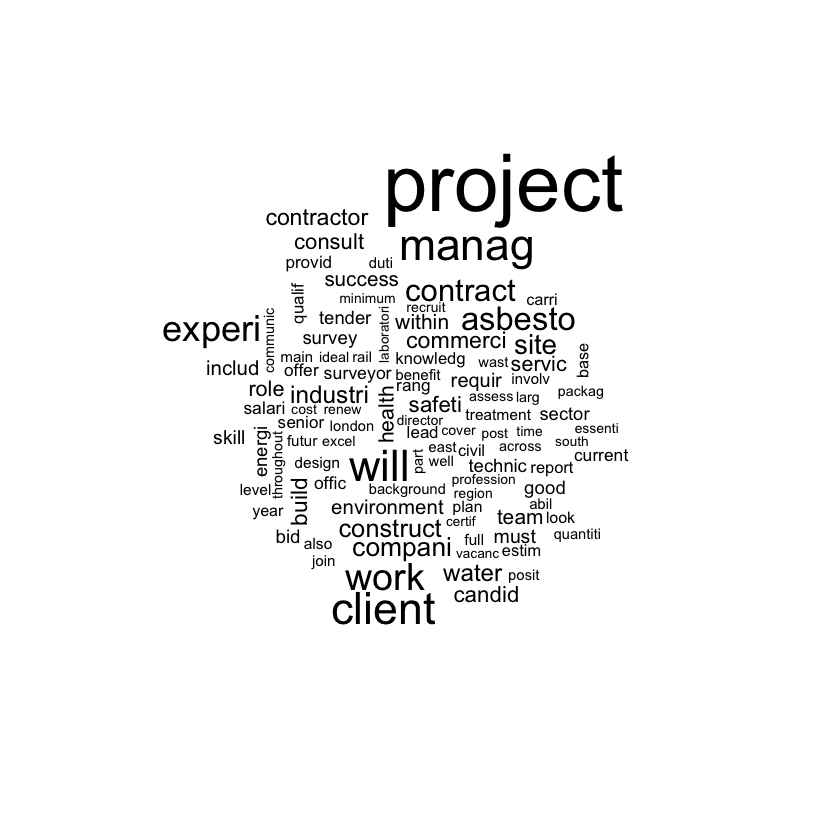

In [149]:
chosen_topic <- 7  # <-- pick one from your labelled topics

theta_train <- stm_fit$theta  # doc-topic proportions for training docs
top_docs_idx <- order(theta_train[, chosen_topic], decreasing = TRUE)[1:2]
top_docs <- meta$FullDescription[top_docs_idx]

cat("\nQ3: Top 2 documents for chosen topic:\n")
cat("\n--- DOC 1 ---\n", top_docs[1], "\n")
cat("\n--- DOC 2 ---\n", top_docs[2], "\n")

# Word cloud for the topic using beta (topic-word distribution)
beta <- exp(stm_fit$beta$logbeta[[1]])  # matrix K x V
topic_word_probs <- beta[chosen_topic, ]
wc_df <- tibble(word = vocab, prob = topic_word_probs) %>%
  arrange(desc(prob)) %>%
  slice_head(n = 150)

set.seed(70104)
wordcloud(words = wc_df$word, freq = wc_df$prob, max.words = 100)


In [150]:
# --- Q4: LASSO classifier with topic proportions (theta) ---

theta_train <- stm_fit$theta

# Binary label: 1 = high salary, 0 = low salary (cutoff = training median)
cutoff <- median(meta$salaryNormalized, na.rm = TRUE)
y_class_train <- ifelse(meta$salaryNormalized > cutoff, 1, 0)

set.seed(70104)
cv_topic_clf <- cv.glmnet(
  x = theta_train,
  y = y_class_train,
  alpha = 1,
  family = "binomial",
  type.measure = "class"   # optimize classification error
)

# Non-zero topics at lambda.min (good predictors)
coef_topic <- as.matrix(coef(cv_topic_clf, s = "lambda.min"))

topic_coef_df <- tibble(
  topic = rownames(coef_topic),
  coef  = as.numeric(coef_topic[, 1])
) %>%
  filter(topic != "(Intercept)", coef != 0) %>%
  mutate(
    topic_num = as.integer(gsub("^V", "", topic)),
    direction = ifelse(coef > 0, "predicts HIGH salary", "predicts LOW salary"),
    abs_coef = abs(coef)
  ) %>%
  arrange(desc(abs_coef))

topic_coef_df


topic,coef,topic_num,direction,abs_coef
<chr>,<dbl>,<int>,<chr>,<dbl>
V2,-7.97519319,2,predicts LOW salary,7.97519319
V18,3.86618802,18,predicts HIGH salary,3.86618802
V3,-3.22046397,3,predicts LOW salary,3.22046397
V19,2.77153866,19,predicts HIGH salary,2.77153866
V9,2.51514205,9,predicts HIGH salary,2.51514205
V8,1.76660132,8,predicts HIGH salary,1.76660132
V5,1.61670391,5,predicts HIGH salary,1.61670391
V17,-1.57874699,17,predicts LOW salary,1.57874699
V13,1.57112016,13,predicts HIGH salary,1.57112016


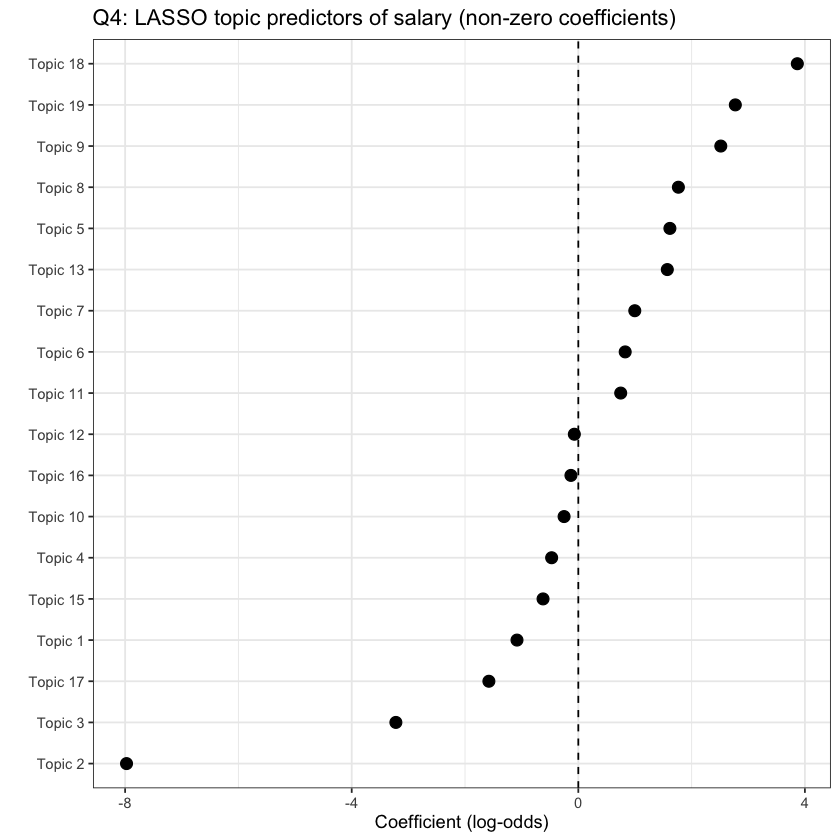

In [151]:
ggplot(topic_coef_df, aes(x = coef, y = reorder(paste0("Topic ", topic_num), coef))) +
  geom_vline(xintercept = 0, linetype = "dashed") +
  geom_point(size = 3) +
  theme_bw() +
  labs(title = "Q4: LASSO topic predictors of salary (non-zero coefficients)",
       x = "Coefficient (log-odds)", y = "")


Warning message in dfm2stm(x, docvars, omit_empty = TRUE):
“Dropped 11,317 zero-count feature(s)”


....................................................................................................

[1] 0.5115

Warning message:
“Each time `sentiment_by` is run it has to do sentence boundary disambiguation when a
raw `character` vector is passed to `text.var`. This may be costly of time and
memory.  It is highly recommended that the user first runs the raw `character`
vector through the `get_sentences` function.”
Warning message:
“Each time `sentiment_by` is run it has to do sentence boundary disambiguation when a
raw `character` vector is passed to `text.var`. This may be costly of time and
memory.  It is highly recommended that the user first runs the raw `character`
vector through the `get_sentences` function.”


[1] 0.516

[1] 0.515

[1] 0.785

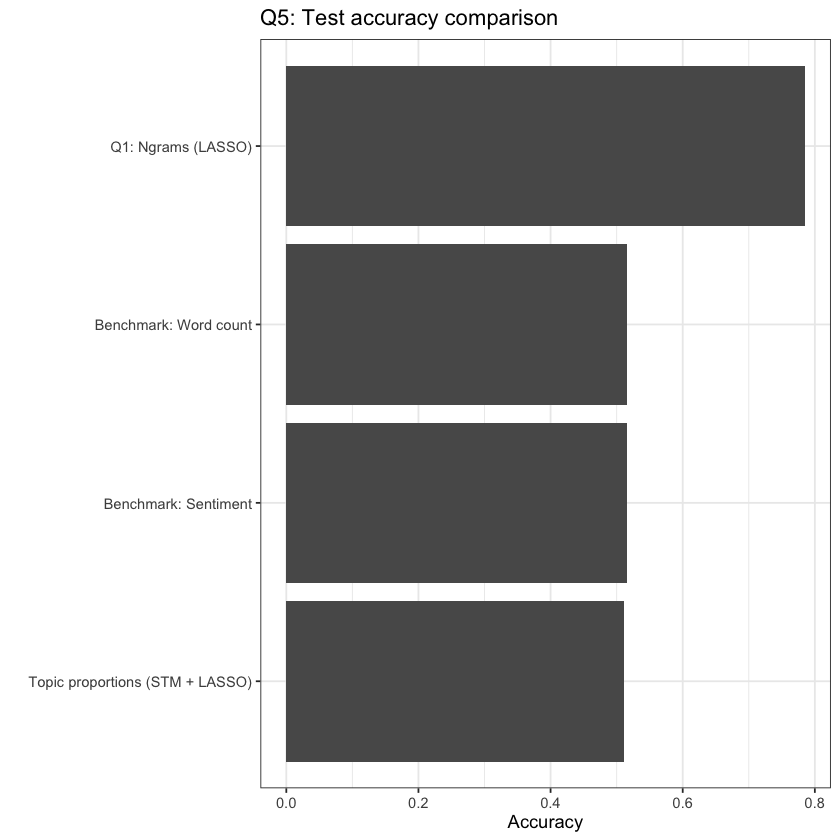

In [155]:
# --- Q5a: infer topic proportions for the TEST set (same STM topics) ---

library(quanteda)

# Tokenize test text in the SAME way you tokenized training for STM
toks_test <- tokens(
  test$FullDescription,
  remove_punct = TRUE,
  remove_numbers = TRUE
) %>%
  tokens_tolower() %>%
  tokens_remove(stopwords("en")) %>%
  tokens_wordstem()

# Build dfm and FORCE it onto the STM model vocab
dfm_test_stm <- dfm(toks_test)

# match features to stm_fit$vocab (same terms, same order)
dfm_test_stm <- dfm_match(dfm_test_stm, features = stm_fit$vocab)

# Drop empty docs (STM can't fit them)
keep <- ntoken(dfm_test_stm) > 0
dfm_test_stm <- dfm_test_stm[keep, ]
test_keep <- test[keep, ]

# Convert to STM format
stm_input_test <- convert(dfm_test_stm, to = "stm")
docs_test <- stm_input_test$documents
# stm_input_test$vocab should now match stm_fit$vocab

# Fit new documents (your version: NO vocab argument)
test_fit <- fitNewDocuments(stm_fit, documents = docs_test)
theta_test <- test_fit$theta

# --- Q5b: evaluate topic-based classifier accuracy ---

y_class_test <- ifelse(test_keep$salaryNormalized > cutoff, 1, 0)

p_topic <- as.numeric(predict(cv_topic_clf, newx = theta_test, s = "lambda.min", type = "response"))
pred_topic <- ifelse(p_topic >= 0.5, 1, 0)
acc_topic <- mean(pred_topic == y_class_test, na.rm = TRUE)
acc_topic

# --- Q5c: Benchmarks (word count and sentiment) ---

wc_train <- stringr::str_count(meta$FullDescription, "\\S+")
wc_test  <- stringr::str_count(test_keep$FullDescription, "\\S+")

m_wc <- glm(y_class_train ~ wc_train, family = binomial())
p_wc <- predict(m_wc, newdata = data.frame(wc_train = wc_test), type = "response")
pred_wc <- ifelse(p_wc >= 0.5, 1, 0)
acc_wc <- mean(pred_wc == y_class_test, na.rm = TRUE)

sent_train <- sentimentr::sentiment_by(meta$FullDescription)$ave_sentiment
sent_test  <- sentimentr::sentiment_by(test_keep$FullDescription)$ave_sentiment

m_sent <- glm(y_class_train ~ sent_train, family = binomial())
p_sent <- predict(m_sent, newdata = data.frame(sent_train = sent_test), type = "response")
pred_sent <- ifelse(p_sent >= 0.5, 1, 0)
acc_sent <- mean(pred_sent == y_class_test, na.rm = TRUE)

acc_wc
acc_sent


# --- Q5d: Q1 model refit as a classifier (ngram LASSO logistic) ---

# Make sure x_test matches the same test rows that survived prepDocuments()
# If you already built x_test from the full test set earlier, rebuild it on prep_test$meta.

dfm_test2 <- make_dfm_ngrams(prep_test$meta$FullDescription, n = 2, min_termfreq = 5)
dfm_test2 <- dfm_match(dfm_test2, features = colnames(x_train))
x_test2 <- as(dfm_test2, "dgCMatrix")

cv_ngram_clf <- cv.glmnet(
  x = x_train,
  y = y_class_train,
  alpha = 1,
  family = "binomial",
  type.measure = "class"
)

p_ngram <- as.numeric(predict(cv_ngram_clf, newx = x_test2, s = "lambda.min", type = "response"))
pred_ngram <- ifelse(p_ngram >= 0.5, 1, 0)
acc_ngram <- mean(pred_ngram == y_class_test, na.rm = TRUE)

acc_ngram


# --- Q5e: plot accuracy scores ---

acc_df <- tibble::tibble(
  model = c(
    "Topic proportions (STM + LASSO)",
    "Benchmark: Word count",
    "Benchmark: Sentiment",
    "Q1: Ngrams (LASSO)"
  ),
  accuracy = c(acc_topic, acc_wc, acc_sent, acc_ngram)
)

ggplot2::ggplot(acc_df, ggplot2::aes(x = reorder(model, accuracy), y = accuracy)) +
  ggplot2::geom_col() +
  ggplot2::coord_flip() +
  ggplot2::theme_bw() +
  ggplot2::labs(
    title = "Q5: Test accuracy comparison",
    x = "",
    y = "Accuracy"
  )


In [162]:
sort(unique(tolower(trimws(jd$ContractType))))
sort(unique(tolower(trimws(jd$ContractTime))))

[1] "full_time"

[1] "permanent"

In [165]:
# --- Q6: Filter to top 5 categories, permanent full-time only ---

jd2 <- jd %>%
  filter(
    !is.na(FullDescription),
    !is.na(Category),
    !is.na(ContractType),
    !is.na(ContractTime)
  ) %>%
  mutate(
    ContractType = str_to_lower(str_trim(ContractType)),
    ContractTime = str_to_lower(str_trim(ContractTime)),
    ContractTime = str_replace_all(ContractTime, "[-\\s]+", "_")
  ) %>%
  filter(
    ContractType == "full_time",
    ContractTime == "permanent"
  )

top5 <- jd2 %>%
  count(Category, sort = TRUE) %>%
  slice_head(n = 5) %>%
  pull(Category)

jd5 <- jd2 %>% filter(Category %in% top5)

nrow(jd5)          # should be 5057
table(jd5$Category)

[1] 5057


       Accounting & Finance Jobs                 Engineering Jobs 
                            1435                              868 
                         IT Jobs PR, Advertising & Marketing Jobs 
                            1191                              757 
                   Teaching Jobs 
                             806 

In [166]:
set.seed(70104)
train_idx <- sample(seq_len(nrow(jd5)), 4000)

train5 <- jd5[train_idx, ]
test5  <- jd5[-train_idx, ]

nrow(train5); nrow(test5)


[1] 4000

[1] 1057

In [167]:
# --- Text features: unigrams (you can set n=2 for bigrams too) ---

dfm_train5 <- make_dfm_ngrams(train5$FullDescription, n = 1, min_termfreq = 5)
dfm_test5  <- make_dfm_ngrams(test5$FullDescription,  n = 1, min_termfreq = 5)
dfm_test5  <- dfm_match(dfm_test5, features = featnames(dfm_train5))

x_train5 <- as(dfm_train5, "dgCMatrix")
x_test5  <- as(dfm_test5,  "dgCMatrix")

y_train5 <- as.factor(train5$Category)
y_test5  <- as.factor(test5$Category)

set.seed(70104)
cv_multi <- cv.glmnet(
  x = x_train5,
  y = y_train5,
  family = "multinomial",
  alpha = 1,
  type.measure = "class"
)

pred_cat <- predict(cv_multi, newx = x_test5, s = "lambda.min", type = "class")
pred_cat <- as.vector(pred_cat)

# Confusion matrix
cm <- table(True = y_test5, Pred = pred_cat)
cm

# Overall accuracy
acc_multi <- sum(diag(cm)) / sum(cm)
acc_multi


                                  Pred
True                               Accounting & Finance Jobs Engineering Jobs
  Accounting & Finance Jobs                              276                3
  Engineering Jobs                                         6              146
  IT Jobs                                                 19               28
  PR, Advertising & Marketing Jobs                         4                1
  Teaching Jobs                                            9                4
                                  Pred
True                               IT Jobs PR, Advertising & Marketing Jobs
  Accounting & Finance Jobs             18                                4
  Engineering Jobs                      23                                0
  IT Jobs                              206                                7
  PR, Advertising & Marketing Jobs       9                              131
  Teaching Jobs                         11                               1

[1] 0.833491

In [168]:
# Convert confusion table to a data frame and sort misclassifications
cm_df <- as.data.frame(cm) %>%
  filter(True != Pred) %>%
  arrange(desc(Freq))

head(cm_df, 10)  # top 10 most common mistakes


,True,Pred,Freq
,<fct>,<fct>,<int>
1,IT Jobs,Engineering Jobs,28
2,Engineering Jobs,IT Jobs,23
3,IT Jobs,Accounting & Finance Jobs,19
4,Accounting & Finance Jobs,IT Jobs,18
5,Teaching Jobs,"PR, Advertising & Marketing Jobs",17
6,Teaching Jobs,IT Jobs,11
7,Teaching Jobs,Accounting & Finance Jobs,9
8,"PR, Advertising & Marketing Jobs",IT Jobs,9
9,IT Jobs,"PR, Advertising & Marketing Jobs",7


In [173]:
library(knitr)

cm_pretty <- as.matrix(cm)

kable(
  cm_pretty,
  caption = "Confusion matrix: Actual (rows) vs Predicted (columns)"
)




Table: Confusion matrix: Actual (rows) vs Predicted (columns)

|                                 | Accounting & Finance Jobs| Engineering Jobs| IT Jobs| PR, Advertising & Marketing Jobs| Teaching Jobs|
|:--------------------------------|-------------------------:|----------------:|-------:|--------------------------------:|-------------:|
|Accounting & Finance Jobs        |                       276|                3|      18|                                4|             2|
|Engineering Jobs                 |                         6|              146|      23|                                0|             5|
|IT Jobs                          |                        19|               28|     206|                                7|             0|
|PR, Advertising & Marketing Jobs |                         4|                1|       9|                              131|             6|
|Teaching Jobs                    |                         9|                4|      11|            